#**Agents**

We built a router.

* Our llm will decide to make a tool call or not based upon the user input
* We use a conditional edge to route to a node that will call our tool or end

In the above router, we invoked the llm and, if it chose to call a tool, It returned a `ToolMessage` to the user.

But, what if we simply pass that `ToolMessage` *back to the llm*?

We can either call 
 - Another tool 

	 OR
- Respond directly 

###**ReAct Agent** : It is a general agent architecture
* `act` - let the llm call specific tools
* `observe` - pass the tool output back to the llm
* `reason` - let the llm reason about the tool output to decide what to do next 
 Call another tool or just respond directly)


In [2]:
!pip install --quiet -U langchain_openai langchain_core langgraph langgraph-prebuilt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.4/63.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.3/438.3 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 7.8 MB/s eta 0:00:00



###**Retrive API key from Secrets and Set as an ENV**

In [3]:
# Retrieve the API key from Colab's secrets
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

# Set OPENAI_API_KEY as an ENV
import os
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY

In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")

In [21]:
def add(a: int, b: int) -> int:
    """Addition"""
    return a + b

def sub(a: int, b: int) -> int:
    """Subtraction"""
    return a - b

def multiply(a: int, b: int) -> int:
    """Multiply"""
    return a * b

def divide(a: int, b: int) -> float:
    """Division"""
    return a / b

def modulo(a: int, b: int) -> int:
    """Modulo"""
    return a % b

def percentage(part: float, whole: float) -> float:
    """Percentage"""
    if whole == 0:
        return 0.0
    return (part / whole) * 100

tools = [add, sub, multiply, divide, modulo, percentage]
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

Let's create our LLM and prompt it with the overall desired agent behavior.

In [22]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

The `Assistant` node is an llm with bound tools. We create a graph with `Assistant` and `Tools` nodes.

We add `tools_condition` edge, which routes to `End` or to `Tools` based on  whether the `Assistant` calls a tool.

We connect the `Tools` node **back** to the `Assistant`(loop)

* Once the assistant node runs, tools_condition evaluates whether the output involves a tool call.
* If a tool call is detected, control moves to the tools node.
* The tools node then routes the flow back to the assistant node.
* This cycle repeats as long as the model continues making tool calls.
* When the model no longer makes a tool call, the flow proceeds to END, completing the process.

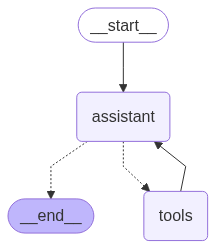

In [23]:
from langgraph.prebuilt import tools_condition
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the last message (result) from assistant node is a tool call ->  routes to tools
    # If the last message (result) from assistant node is not a tool call -> routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [30]:
messages1 = [HumanMessage(content="do the total of 5 and 4. Multiply the output by 7. Divide the output by 2")]
messages1 = react_graph.invoke({"messages": messages1})

In [45]:
messages = [HumanMessage(content="I bought 3 sarees of Rupees 5000. Shopkeeper gave me 10% discount. How much I should Pay? ")]
messages = react_graph.invoke({"messages": messages})

####**Note:** Not everytime LLM will choose the same sequence of tools. Please rerun the Graph to see the difference

In [44]:
for m in messages['messages']:
#for m in messages1['messages']:
    m.pretty_print()

================================ Human Message =================================

I bought 3 sarees of Rupees 5000. Shopkeeper gave me 10% discount. How mauch I should Pay? 
================================== Ai Message ==================================
Tool Calls:
  multiply (call_lmXHCUCc0ZCbLFSq3gn9NpE3)
 Call ID: call_lmXHCUCc0ZCbLFSq3gn9NpE3
  Args:
    a: 3
    b: 5000
================================= Tool Message =================================
Name: multiply

15000
================================== Ai Message ==================================
Tool Calls:
  percentage (call_Juf40uHAsSoekad1bUzOA7lI)
 Call ID: call_Juf40uHAsSoekad1bUzOA7lI
  Args:
    part: 10
    whole: 15000
================================= Tool Message =================================
Name: percentage

0.06666666666666667
================================== Ai Message ==================================
Tool Calls:
  sub (call_QjHjU9CAPCHdTGFBsHiYwrq1)
 Call ID: call_QjHjU9CAPCHdTGFBsHiYwrq1
  Args:
    